In [1]:
import gymnasium as gym
import numpy as np
import d3rlpy
import pickle

import matplotlib.pyplot as plt
from env.atari.represented_atari_game import GymCompatWrapper2
from online_main import OneHotWrapper
from pretrain_from_llm import get_llm_data_paths
from vis_utils import *

# hyperparams = {
#     "env": "CliffWalking-v0",  # CartPole-v0, Pendulum-v1, MountainCar-v0, FrozenLake-v1, CliffWalking-v0, RepresentedPong-v0
#     "n_online_eps": 170,  # 10-5990 for mountainCar, 30-120 for CartPole
hyperparams = {
    "env": "FrozenLake-v1",  # CartPole-v0, Pendulum-v1, MountainCar-v0, FrozenLake-v1, CliffWalking-v0, RepresentedPong-v0
    "n_online_eps": 120,  # 10-5990 for mountainCar, 30-120 for CartPole
    "n_pretrain_eps": 30,
    "seed": 42069,
    "max_episode_len": 200,  # Around 10h per 100k steps in Leviathan server
    "eps": 0.1,  # epsilon for exploration
    "n_exp": 5,
    "gpu": True,  # True if use GPU to train with d3rlpy
    "buffer_size": 100000,  # Test with 100k, 200k, 500k. 1M might be too much
    "data_path": None,  #'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
    "model_path": None,  #'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
    "batch_size": 256,  # Test smaller batch size: 32, 64. May be noisier
    "learning_rate": 5e-5,
    "gamma": 0.99,
    "target_update_interval": 1000,  # Test with 1k, 2k, 5k
    "smooth": 10,  # For plotting, smooth the curve with this window size
    # "n_episodes": 150,
}

hyperparams["n_episodes"] = hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
# assert (
#     hyperparams["n_episodes"]
#     == hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
# ), "Check n_episodes=n_pretrain_eps+n_online_eps"

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
elif isinstance(gym.make(hyperparams["env"]).observation_space, gym.spaces.Discrete):
    env = OneHotWrapper(gym.make(hyperparams["env"]))
    eval_env = OneHotWrapper(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"])
    eval_env = gym.make(hyperparams["env"])

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

2025-08-29 15:10.19 [info     ] Register Shimmy environments. 


/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Static/pretrain data

In [2]:
path_7b, path_32b = get_llm_data_paths(hyperparams["env"])

with open(path_7b, "rb") as file:
    Qwen_7B_dataset = pickle.load(file)
with open(path_32b, "rb") as file:
    Qwen_32B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_7B = hyperparams["n_episodes"] * [np.mean(Qwen_7B_rewards)]
Qwen_32B = hyperparams["n_episodes"] * [np.mean(Qwen_32B_rewards)]

print("Qwen_32B: ", np.mean(Qwen_7B_rewards))
print("Qwen_7B: ", np.mean(Qwen_32B_rewards))

Qwen_32B:  0.0
Qwen_7B:  0.0


In [3]:
try:
    env_name = hyperparams["env"].split("-")[0]
    if env_name == "Pendulum":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250422210707SFT.pkl"
    elif env_name == "CliffWalking":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250505135458SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421175530SFT.pkl" #CliffWalking typo
    elif env_name == "FrozenLake":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250501013018SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421120400SFT.pkl" #FrozenLake typo

    with open(path_SFT, "rb") as file:
        Qwen_7B_SFT_dataset = pickle.load(file)

    Qwen_7B_SFT_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        Qwen_7B_SFT_rewards.append(Qwen_7B_SFT_dataset.episodes[i].compute_return())
    Qwen_7B_SFT = Qwen_7B_SFT_rewards + hyperparams["n_online_eps"] * [
        np.mean(Qwen_7B_SFT_rewards)
    ]
    print("Qwen_7B_SFT: ", np.mean(Qwen_7B_SFT_rewards))
except:
    Qwen_7B_SFT = None
try:
    path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250502071148.pkl"  # FrozenLake
    path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250502084016.pkl"  # FrozenLake
    # path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250419172821.pkl" #FrozenLake typo
    # path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250422000525.pkl" #FrozenLake typo
    with open(path_DS_7B, "rb") as file:
        DS_7B_dataset = pickle.load(file)
    with open(path_DS_14B, "rb") as file:
        DS_14B_dataset = pickle.load(file)
    DS_7B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_7B_rewards.append(DS_7B_dataset.episodes[i].compute_return())
    DS_14B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_14B_rewards.append(DS_14B_dataset.episodes[i].compute_return())

    DS_7B = hyperparams["n_episodes"] * [np.mean(DS_7B_rewards)]
    DS_14B = hyperparams["n_episodes"] * [np.mean(DS_14B_rewards)]
    # DS_7B = DS_7B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_7B_rewards)]
    # DS_14B = DS_14B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_14B_rewards)]

    print("DS_7B: ", np.mean(DS_7B_rewards))
    print("DS_14B: ", np.mean(DS_14B_rewards))
except:
    DS_7B = None
    DS_14B = None

Qwen_7B_SFT:  0.0
DS_7B:  0.03333333333333333
DS_14B:  0.03333333333333333


### Generate and evaluate random baseline

In [4]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(hyperparams["n_pretrain_eps"]):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    count = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        count += 1
        if count >= hyperparams["max_episode_len"]:
            break
    random_rewards.append(total_reward)

mean_random = np.ones(
    hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
) * np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random[0]}")

Average reward for random policy: 0.0


# Plot

In [5]:
all_cache = extract_data(hyperparams, Qwen_7B, Qwen_32B, DS_7B, DS_14B, Qwen_7B_SFT, mean_random)
# plot_main(hyperparams, all_cache, Qwen_7B, Qwen_32B, mean_random)
# plot_pretrain(hyperparams, all_cache)
# # plot_pretrain_big(hyperparams, all_cache)
# plot_mix(hyperparams, all_cache)
# plot_model_size(hyperparams, all_cache)
# plot_pretrain_step(hyperparams, all_cache)
# plot_pretrain_eps(hyperparams, all_cache)
# # plot_sft_lcot(hyperparams, all_cache)
# plot_sft_lcot_big(hyperparams, all_cache)

Environment is CliffWalking or FrozenLake. Extracting dataset for Transfer Coefficient calculation ...


## Coverage and Transfer Coefficient (FrozenLake and CliffWalking only)

In [6]:
n_online_eval_eps=10
merge_time_step=False #False to calculate the transfer coefficient in the original formula, True to merge the time step to compare coverage of the full sequence
def print_results(offline_dataset, online_dataset, n_pretrain_eps, n_online_eval_eps, text, merge_time_step=False):
    max_transfer_coef, max_key, (no_diff, no_online_keys, no_offline_keys, no_diff2) = datasets_to_transfer_coef_upper_bound(online_dataset, offline_dataset, n_pretrain_eps, n_online_eval_eps, merge_time_step=merge_time_step)
    if max_transfer_coef != np.inf:
        print(f"{text}: Max transfer coef: {max_transfer_coef} at step {max_key[0]}, state {max_key[1]}, action {max_key[2]}")
    else:
        print(f"{text}: Max transfer coef: inf")
    print(f"No of online keys: {no_online_keys}. No of offline keys: {no_offline_keys}. No online not offline: {no_diff}. No offline not online: {no_diff2}")
if hyperparams["env"] == "CliffWalking-v0" or hyperparams["env"] == "FrozenLake-v1":
    for i in range(hyperparams["n_exp"]):
        print(f"Experiment {i}:")
        for n_eps in [30]:
        # for n_eps in [10, 20, 30]:
            Qwen_7B_LORO_1000_Neps_dataset = all_cache[f"pretrain_7b_1000_{n_eps}_{i}_dataset"]
            Qwen_32B_LORO_1000_Neps_dataset = all_cache[f"pretrain_32b_1000_{n_eps}_{i}_dataset"]
            on_pol_1000_Neps_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_dataset"]
            on_pol_1000_Neps_offline_dataset = all_cache[f"on_pol_1000_{n_eps}_{i}_offline_dataset"]
            rand_1000_Neps_dataset = all_cache[f"rand_1000_{n_eps}_{i}_dataset"]
            rand_1000_Neps_offline_dataset = all_cache[f"rand_1000_{n_eps}_{i}_offline_dataset"]

            # print_results(Qwen_7B_dataset, Qwen_32B_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Qwen 7B vs Qwen 32B", merge_time_step)
            print_results(Qwen_7B_dataset, Qwen_7B_LORO_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Qwen 7B LORO 1000 {n_eps}", merge_time_step)
            print_results(Qwen_32B_dataset, Qwen_32B_LORO_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Qwen 32B LORO 1000 {n_eps}", merge_time_step)
            print_results(on_pol_1000_Neps_offline_dataset, on_pol_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"On-policy 1000 Neps {n_eps}", merge_time_step)
            print_results(rand_1000_Neps_offline_dataset, rand_1000_Neps_dataset, hyperparams["n_pretrain_eps"], n_online_eval_eps, f"Random 1000 Neps {n_eps}", merge_time_step)
        # print("--------------------------------")
    

Experiment 0:
Qwen 7B LORO 1000 30: Max transfer coef: inf
No of online keys: 269. No of offline keys: 138. No online not offline: 250. No offline not online: 119
Qwen 32B LORO 1000 30: Max transfer coef: inf
No of online keys: 217. No of offline keys: 119. No online not offline: 205. No offline not online: 107
On-policy 1000 Neps 30: Max transfer coef: inf
No of online keys: 320. No of offline keys: 366. No online not offline: 309. No offline not online: 355
Random 1000 Neps 30: Max transfer coef: inf
No of online keys: 299. No of offline keys: 157. No online not offline: 268. No offline not online: 126
Experiment 1:
Qwen 7B LORO 1000 30: Max transfer coef: inf
No of online keys: 343. No of offline keys: 138. No online not offline: 326. No offline not online: 121
Qwen 32B LORO 1000 30: Max transfer coef: inf
No of online keys: 275. No of offline keys: 119. No online not offline: 265. No offline not online: 109
On-policy 1000 Neps 30: Max transfer coef: inf
No of online keys: 337. No o

## For visualization

Total visits: 30
Normalized coverage (first 5 entries): {(0, 1): 0.16666666666666666, (0, 2): 0.3, (1, 1): 0.13333333333333333, (4, 1): 0.1, (4, 2): 0.1}


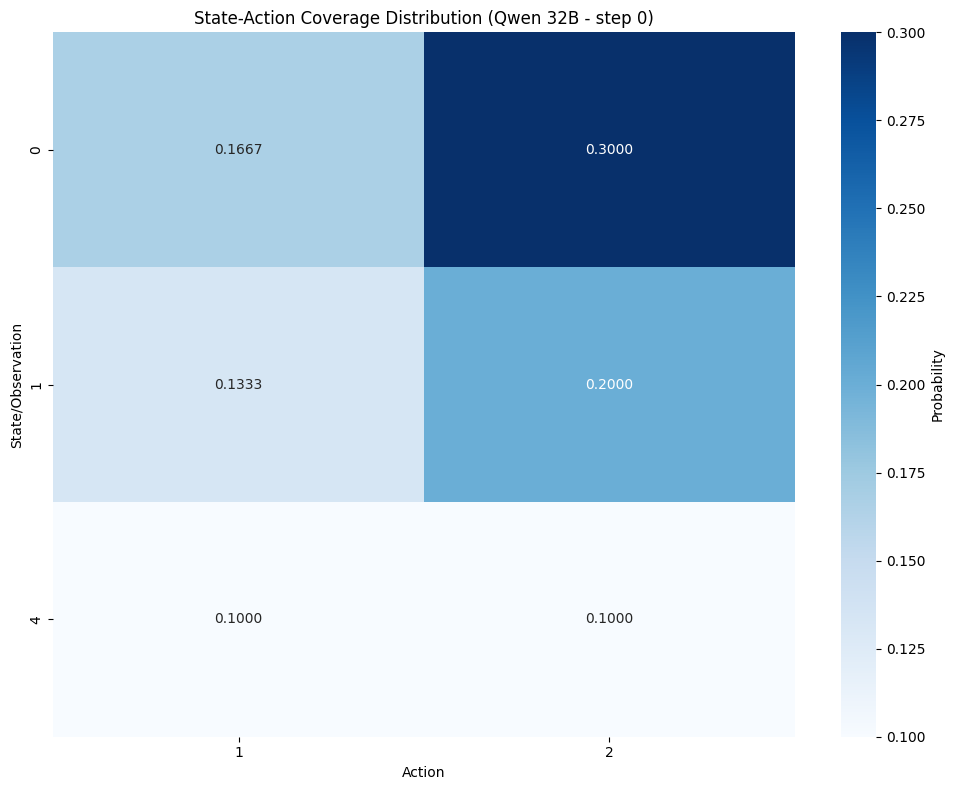

Number of unique state-action pairs: 6
Number of unique states: 3
Number of unique actions: 2
Maximum probability: 0.3000
Minimum probability: 0.1000
--------------------------------
Total visits: 30
Normalized coverage (first 5 entries): {(0, 1): 0.06666666666666667, (1, 2): 0.13333333333333333, (2, 2): 0.13333333333333333, (0, 2): 0.13333333333333333, (1, 1): 0.06666666666666667}


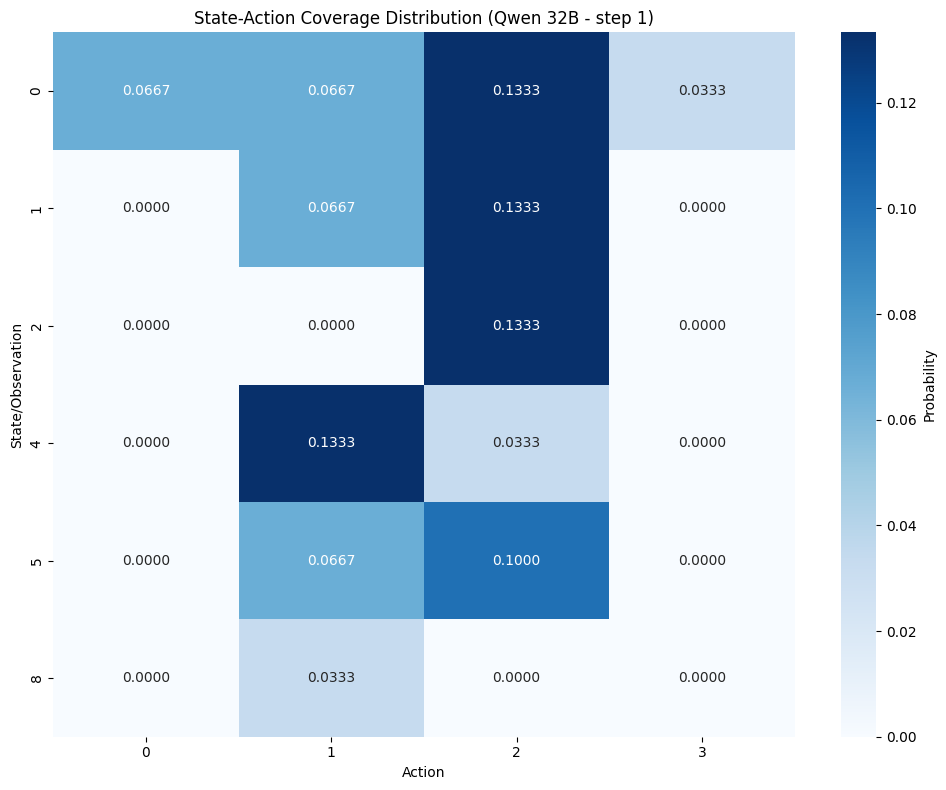

Number of unique state-action pairs: 12
Number of unique states: 6
Number of unique actions: 4
Maximum probability: 0.1333
Minimum probability: 0.0333
--------------------------------
Total visits: 25
Normalized coverage (first 5 entries): {(1, 2): 0.24, (3, 1): 0.08, (4, 2): 0.08, (5, 2): 0.08, (2, 2): 0.08}


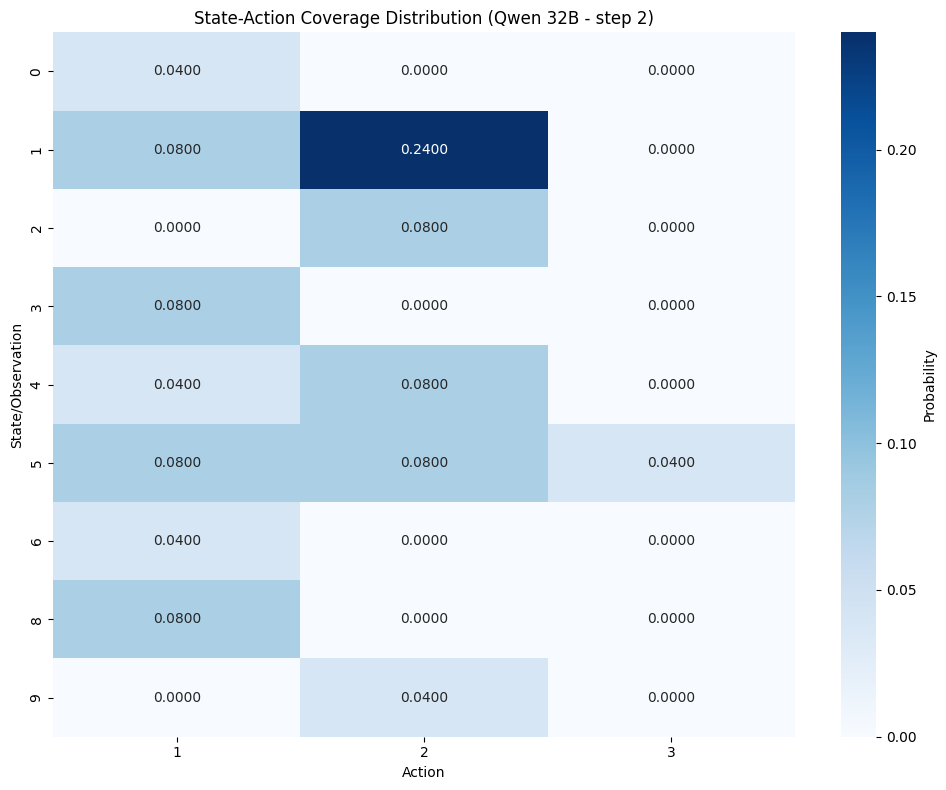

Number of unique state-action pairs: 13
Number of unique states: 9
Number of unique actions: 3
Maximum probability: 0.2400
Minimum probability: 0.0400
--------------------------------
Total visits: 20
Normalized coverage (first 5 entries): {(2, 1): 0.05, (1, 2): 0.2, (7, 0): 0.1, (8, 1): 0.05, (3, 1): 0.1}


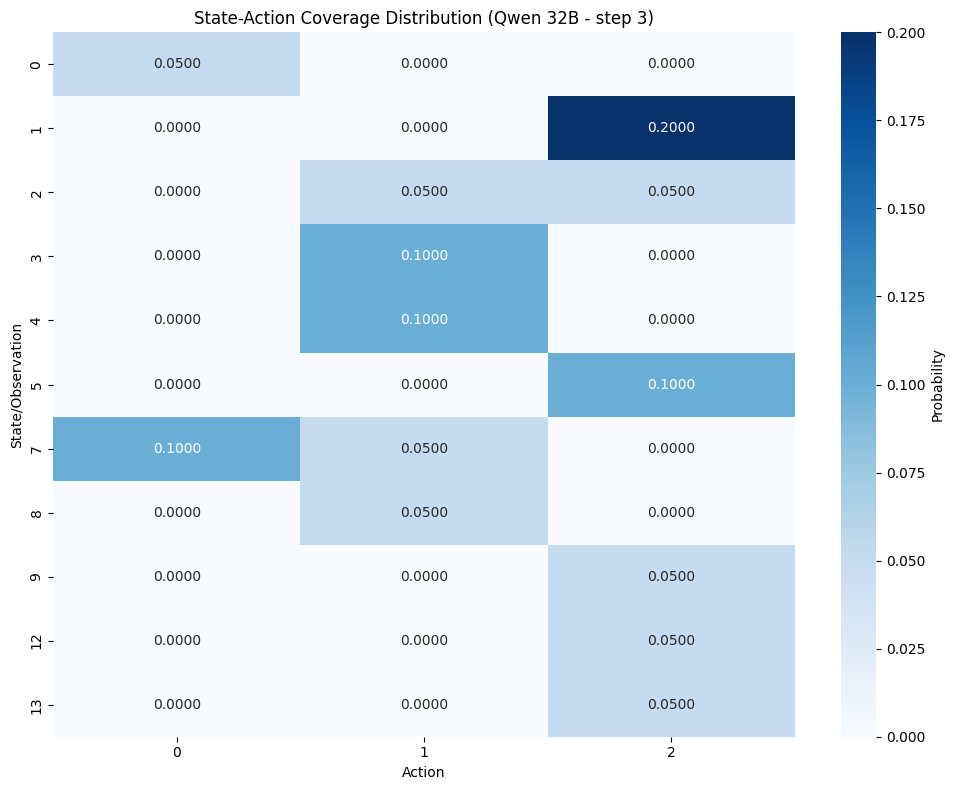

Number of unique state-action pairs: 13
Number of unique states: 11
Number of unique actions: 3
Maximum probability: 0.2000
Minimum probability: 0.0500
--------------------------------
Total visits: 14
Normalized coverage (first 5 entries): {(3, 1): 0.07142857142857142, (2, 1): 0.07142857142857142, (4, 2): 0.07142857142857142, (0, 0): 0.07142857142857142, (7, 0): 0.07142857142857142}


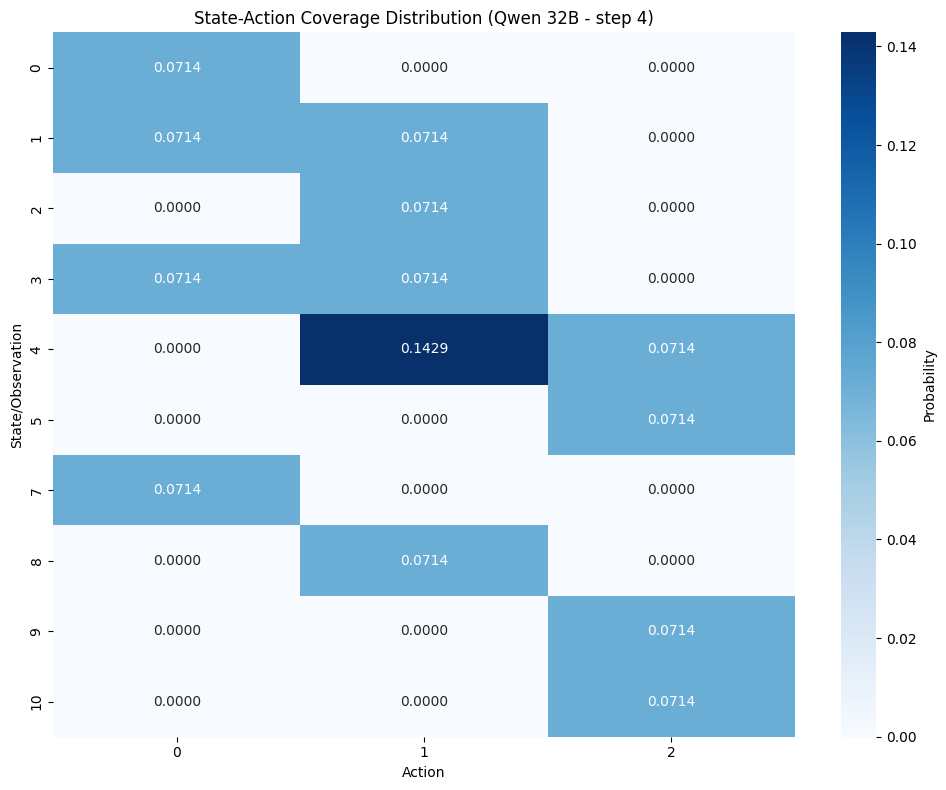

Number of unique state-action pairs: 13
Number of unique states: 10
Number of unique actions: 3
Maximum probability: 0.1429
Minimum probability: 0.0714
--------------------------------
Total visits: 12
Normalized coverage (first 5 entries): {(3, 1): 0.16666666666666666, (4, 1): 0.16666666666666666, (0, 1): 0.08333333333333333, (8, 1): 0.08333333333333333, (1, 2): 0.08333333333333333}


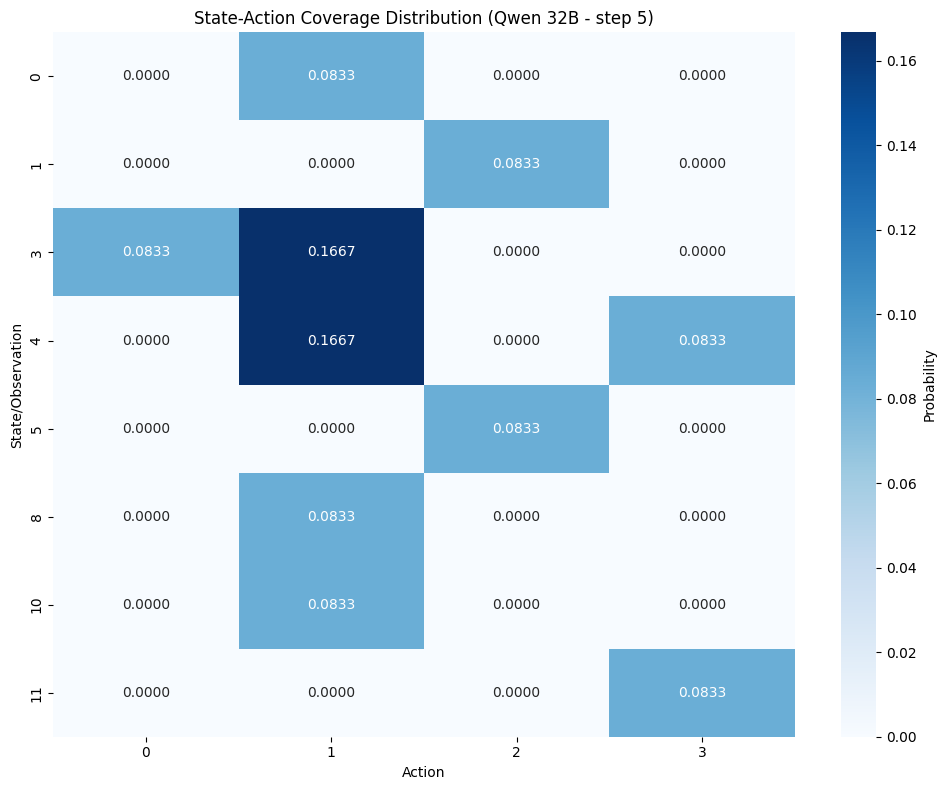

Number of unique state-action pairs: 10
Number of unique states: 8
Number of unique actions: 4
Maximum probability: 0.1667
Minimum probability: 0.0833
--------------------------------
Total visits: 10
Normalized coverage (first 5 entries): {(7, 1): 0.1, (2, 0): 0.1, (4, 3): 0.1, (4, 1): 0.1, (4, 2): 0.1}


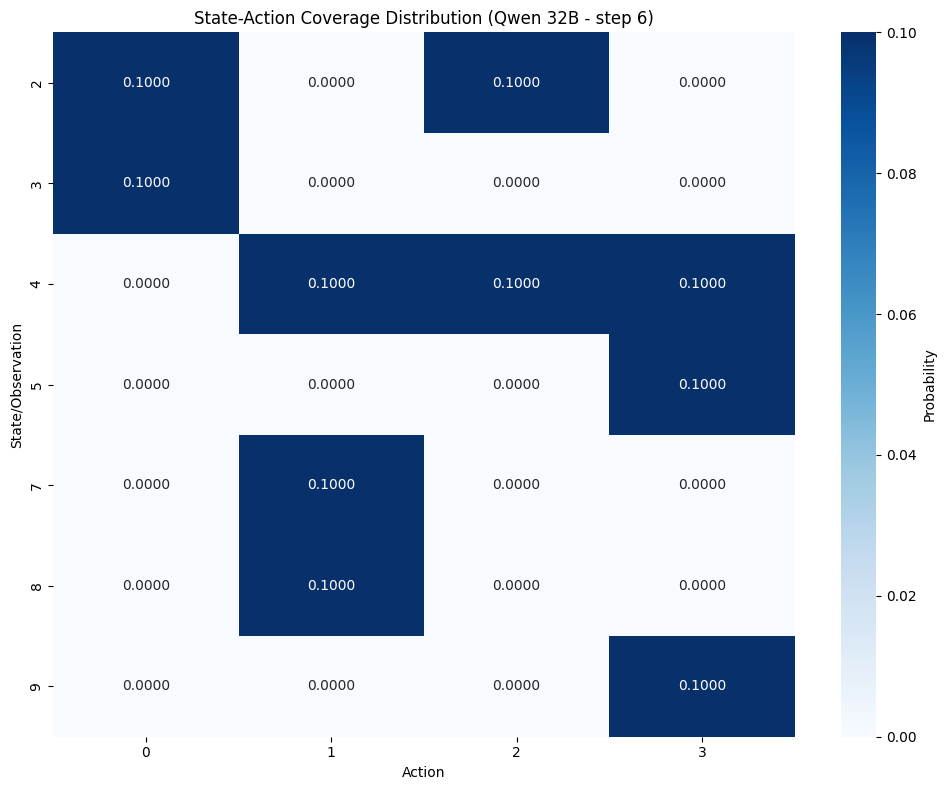

Number of unique state-action pairs: 10
Number of unique states: 7
Number of unique actions: 4
Maximum probability: 0.1000
Minimum probability: 0.1000
--------------------------------
Total visits: 8
Normalized coverage (first 5 entries): {(1, 0): 0.125, (5, 3): 0.125, (5, 1): 0.125, (4, 3): 0.125, (6, 1): 0.125}


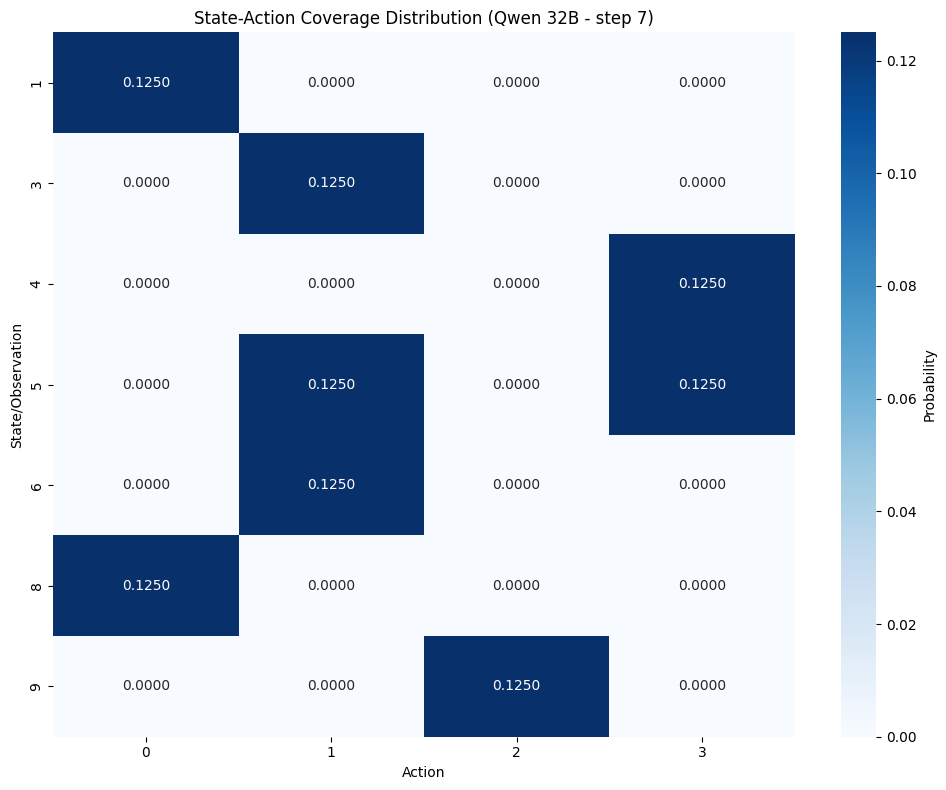

Number of unique state-action pairs: 8
Number of unique states: 7
Number of unique actions: 4
Maximum probability: 0.1250
Minimum probability: 0.1250
--------------------------------
Total visits: 6
Normalized coverage (first 5 entries): {(5, 1): 0.16666666666666666, (4, 3): 0.16666666666666666, (10, 1): 0.3333333333333333, (9, 1): 0.16666666666666666, (7, 0): 0.16666666666666666}


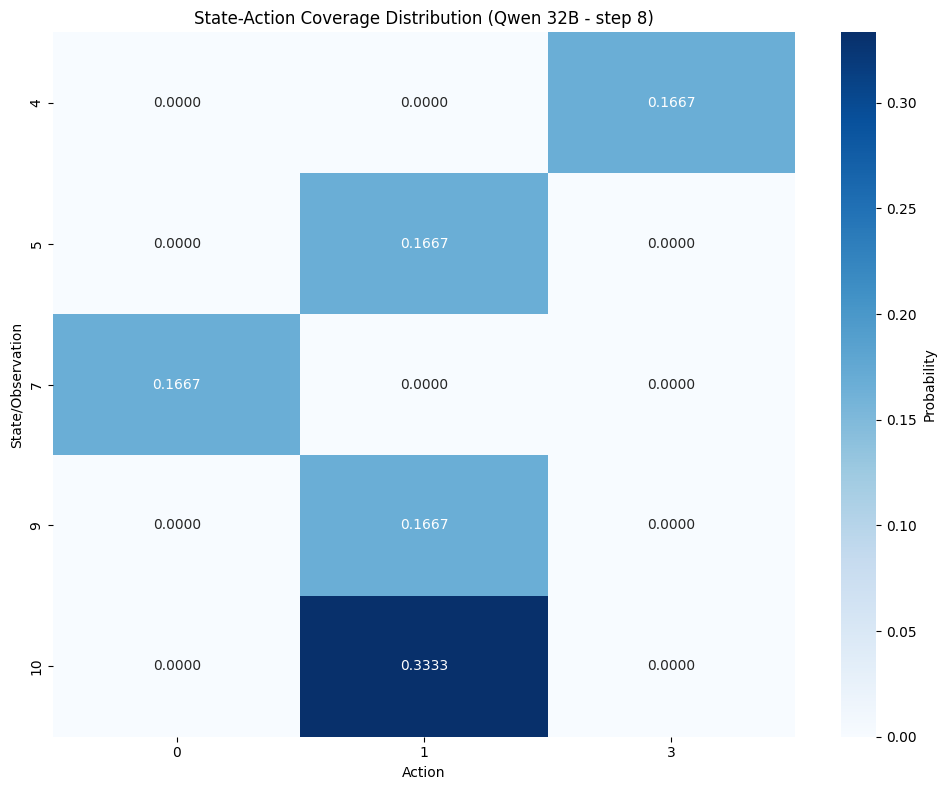

Number of unique state-action pairs: 5
Number of unique states: 5
Number of unique actions: 3
Maximum probability: 0.3333
Minimum probability: 0.1667
--------------------------------
Total visits: 4
Normalized coverage (first 5 entries): {(5, 1): 0.25, (6, 0): 0.25, (13, 2): 0.25, (11, 1): 0.25}


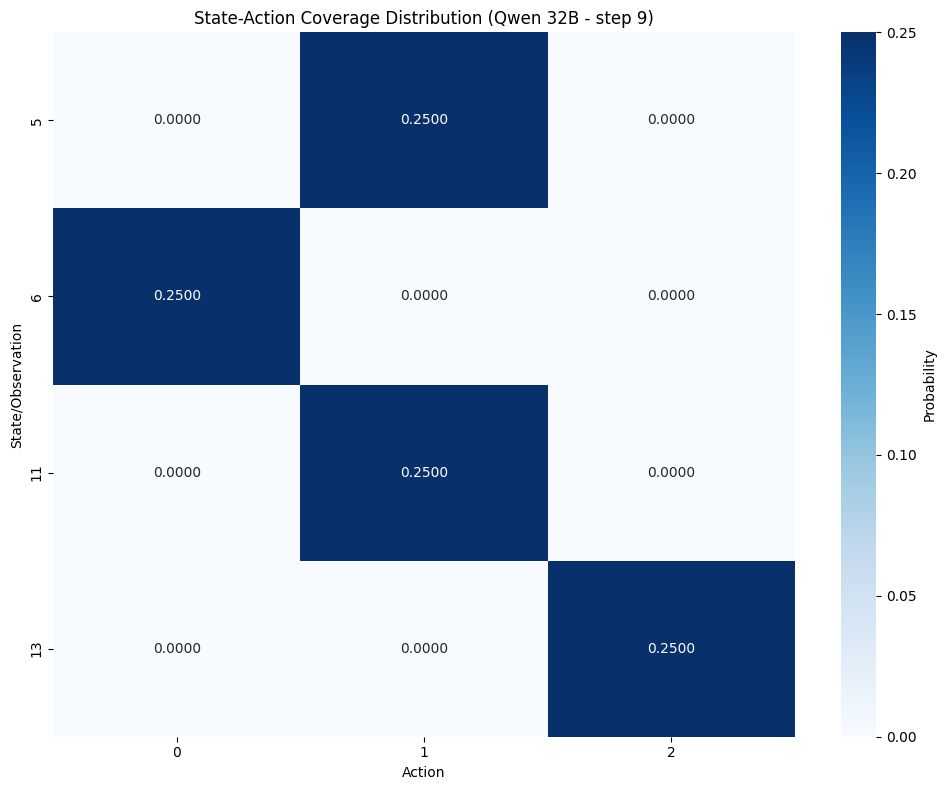

Number of unique state-action pairs: 4
Number of unique states: 4
Number of unique actions: 3
Maximum probability: 0.2500
Minimum probability: 0.2500
--------------------------------
Total visits: 2
Normalized coverage (first 5 entries): {(2, 3): 0.5, (14, 2): 0.5}


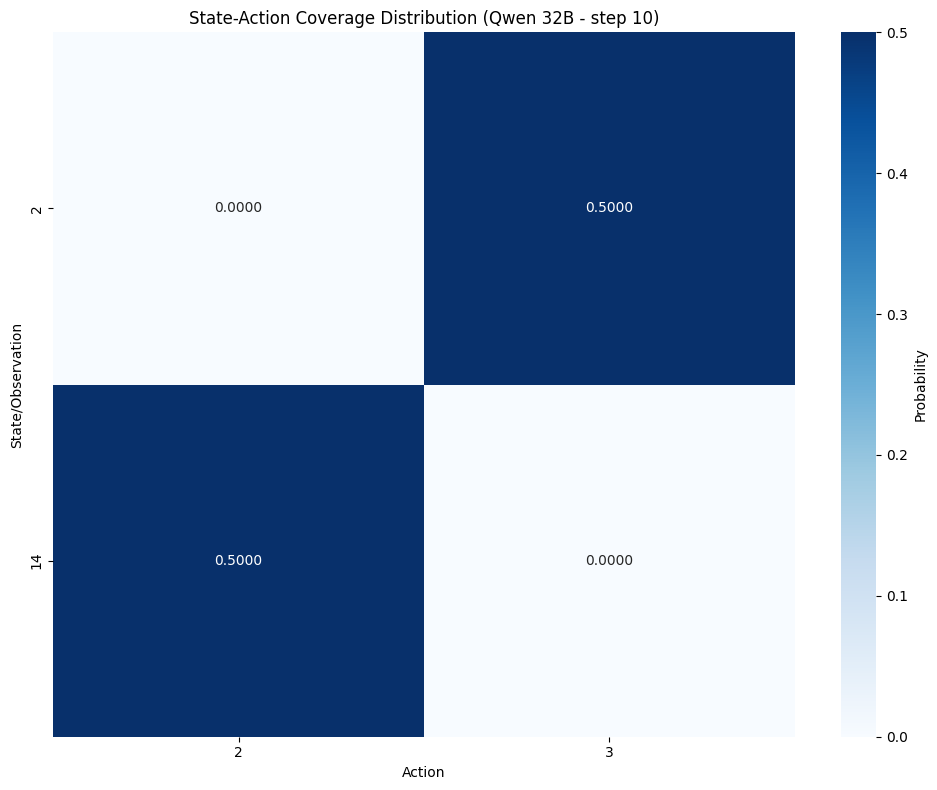

Number of unique state-action pairs: 2
Number of unique states: 2
Number of unique actions: 2
Maximum probability: 0.5000
Minimum probability: 0.5000
--------------------------------
Total visits: 2
Normalized coverage (first 5 entries): {(2, 2): 0.5, (13, 3): 0.5}


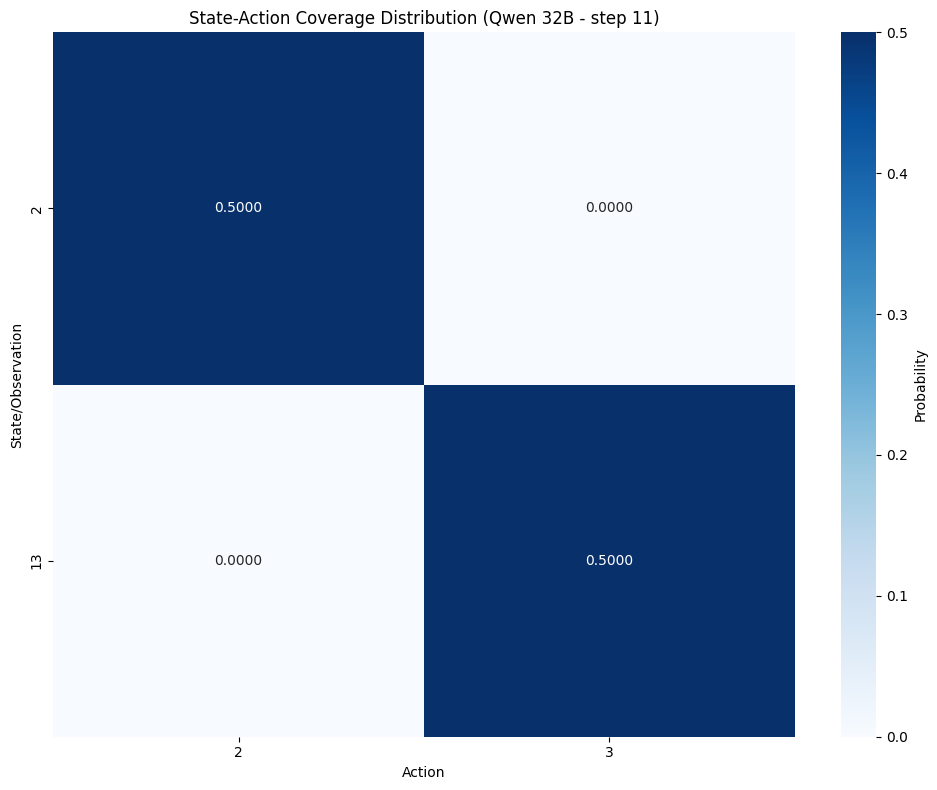

Number of unique state-action pairs: 2
Number of unique states: 2
Number of unique actions: 2
Maximum probability: 0.5000
Minimum probability: 0.5000
--------------------------------
Total visits: 2
Normalized coverage (first 5 entries): {(1, 1): 0.5, (9, 2): 0.5}


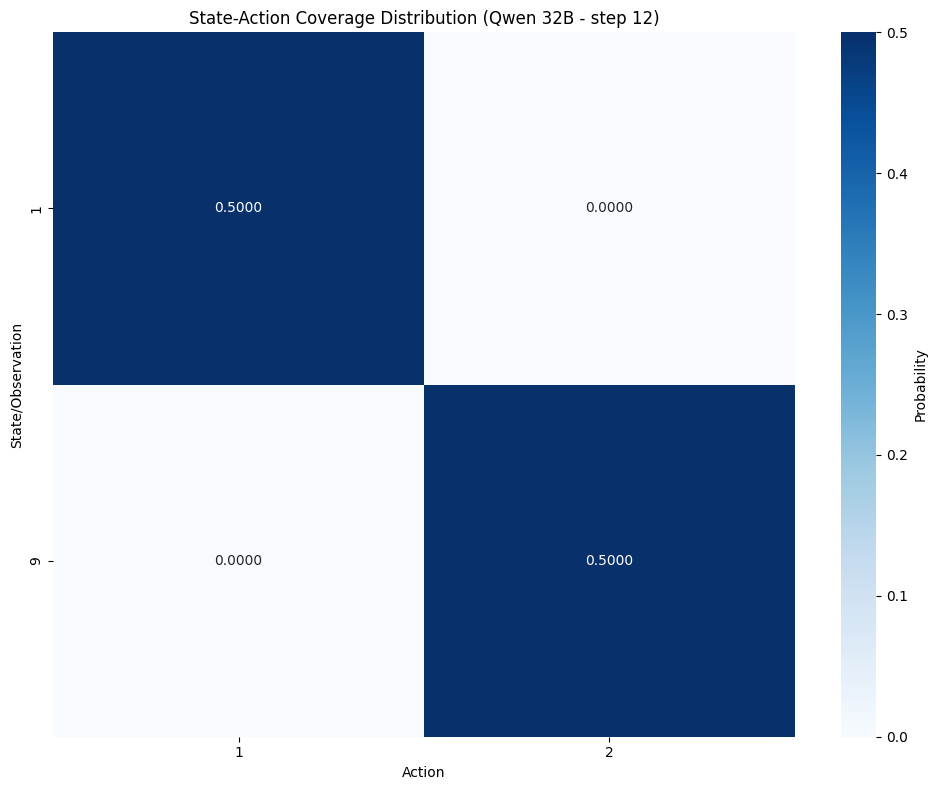

Number of unique state-action pairs: 2
Number of unique states: 2
Number of unique actions: 2
Maximum probability: 0.5000
Minimum probability: 0.5000
--------------------------------
Total visits: 2
Normalized coverage (first 5 entries): {(2, 2): 0.5, (10, 2): 0.5}


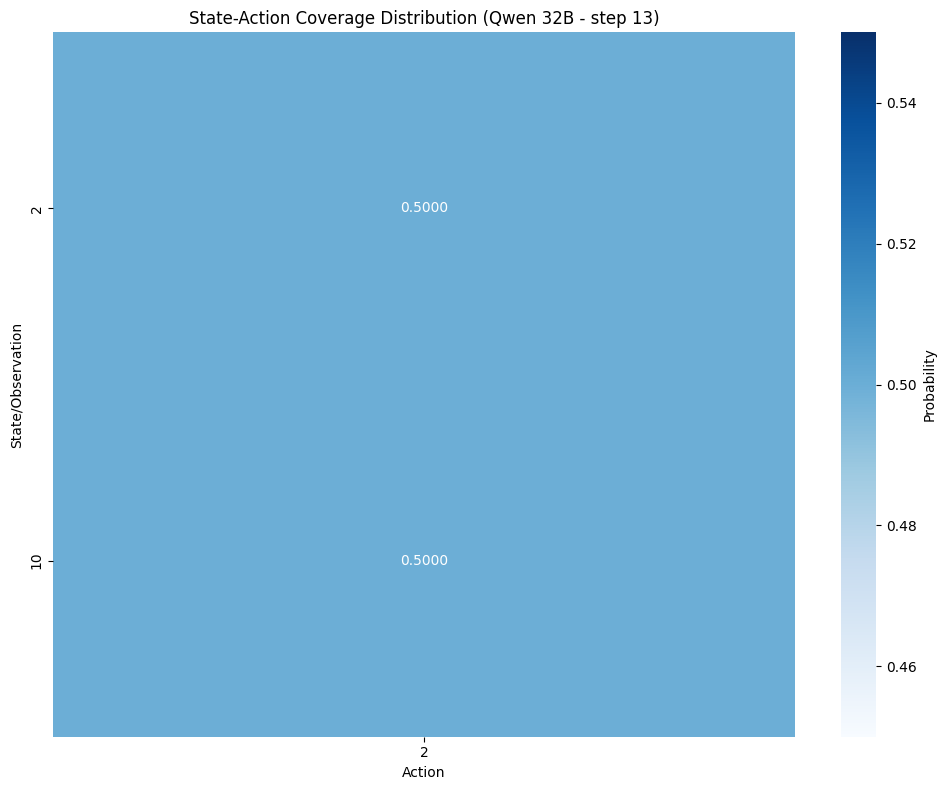

Number of unique state-action pairs: 2
Number of unique states: 2
Number of unique actions: 1
Maximum probability: 0.5000
Minimum probability: 0.5000
--------------------------------
Total visits: 2
Normalized coverage (first 5 entries): {(6, 1): 0.5, (11, 1): 0.5}


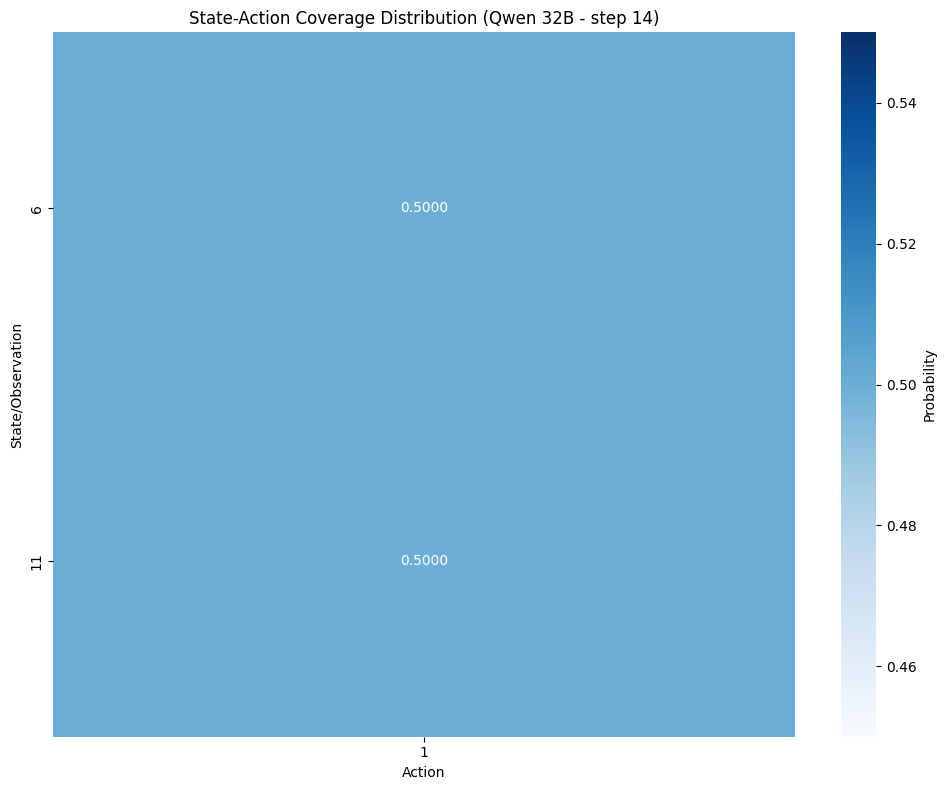

Number of unique state-action pairs: 2
Number of unique states: 2
Number of unique actions: 1
Maximum probability: 0.5000
Minimum probability: 0.5000
--------------------------------


In [7]:
for i in range(15):
    plot_coverage_heatmap(Qwen_32B_dataset, hyperparams["n_pretrain_eps"], i, model_name="Qwen 32B", figsize=(10, 8), cmap='Blues', annot=True, fmt='.4f')